# Run The Agent on Mountain Car

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

import pandas as pd

In [3]:
from vae_recurrent import VAE, create_decoder, create_encoder
# from basic_agent.transition_basic import TransitionFeedForward
# from basic_agent.basic_agent import DAIFAgent
from prior_model import PriorModelBellman
from habitual_action_network import HabitualAction, compute_discounted_cumulative_reward
from ddpg import *

In [4]:
from util import random_observation_sequence, transform_observations, test_policy, habit_policy
from train_agent import train_single_agent

In [5]:
# from identity_vae import IdentityVAE, identity_encoder, identity_decoder

What does the agent do?
- The agent plans using a policy then executes that policy for 12 simulation timesteps, the first two actions of the policy are executed for 6 steps each

What data does it accumulate?
- It accumulates 12 observation actions pairs

How is it trained?
- VAE is trained to reproduce observations using the latent states
- Transition is trained by taking previous hidden state and previous latent state and trying to predict the next latent state


Online learning For all tasks, we initialize all the agents with random weights and learn online only. Training an agent for 150 epochs takes about 3 minutes on a single CPU core (Intel I7-4870HQ). In contrast, previous approaches using active inference [Ueltzhöffer, 2018, Tschantz et al., 2019, 2020] and policy gradient methods (e.g., [Liu et al., 2017]) use (offline) policy replay and typically need hours of GPU-accelerated compute while achieving similar convergence. To our knowledge, this is the first model-based RL method to learn online using neural network representations. This is afforded by the high sample efficiency of the FEEF, which directs exploration towards states that are uncertain for both the encoder and transition models.


Why this is true?

In [6]:
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [6]:
# import tensorflow as tf
# import tensorflow_probability as tfp
# import numpy as np
#
#
# class DAIFAgent:
#
#     def __init__(self,
#                  prior_model,
#                  vae,
#                  tran,
#                  habitual_action_net,
#                  given_prior_mean=None,
#                  given_prior_stddev=None,
#                  agent_time_ratio=6,
#                  actions_to_execute_when_exploring=2,
#                  planning_horizon=15,
#                  n_policies=1500,
#                  n_cem_policy_iterations=2,
#                  n_policy_candidates=70,
#                  train_vae=True,
#                  train_tran=True,
#                  train_prior_model=True,
#                  train_habit_net=True,
#                  train_with_replay=True,
#                  train_after_exploring=True,
#                  use_kl_extrinsic=True,
#                  use_kl_intrinsic=True,
#                  use_FEEF=True,
#                  use_fast_thinking=False,
#                  uncertainty_tolerance=0.05,
#                  habit_model_type="name_of_model",
#                  min_rewards_needed_to_train_prior=0):
#
#         super(DAIFAgent, self).__init__()
#
#         # parameters for slow policy planning
#         self.planning_horizon = planning_horizon
#         self.n_policy_candidates = n_policy_candidates
#         self.n_policies = n_policies
#         self.n_cem_policy_iterations = n_cem_policy_iterations
#
#         # flags for whether or not we are training models or using pretrained models and when we should train
#         self.train_vae = train_vae
#         self.train_tran = train_tran
#         self.train_habit_net = train_habit_net
#         self.train_prior = train_prior_model
#         self.train_with_replay = train_with_replay
#         self.train_after_exploring = train_after_exploring
#
#         # do we use the kl divergence for extrinsic vs intrinsic
#         self.use_kl_intrinsic = use_kl_intrinsic
#         self.use_kl_extrinsic = use_kl_extrinsic
#
#         # do we use the FEEF or EFE?
#         self.use_FEEF = use_FEEF
#
#         # given prior values
#         self.given_prior_mean = given_prior_mean
#         self.given_prior_stddev = given_prior_stddev
#
#         # full vae
#         self.model_vae = vae
#         self.tran = tran
#         self.prior_model = prior_model
#         self.habit_action_model = habitual_action_net
#
#         # how much is the agents planning time compressed compared to the simulation time
#         self.agent_time_ratio = agent_time_ratio
#         self.actions_to_execute_when_exploring = actions_to_execute_when_exploring
#         self.time_step = 0
#         self.exploring = False
#
#         # track the hidden state of the transition gru model so we can use it to train
#         # self.tran_hidden_state = None
#         # self.tran_hidden_state_pre_exploring = None
#         # self.prev_tran_hidden_state = None
#
#         # store the full observations for the episode so we can train using replay
#         self.full_observation_sequence = []
#         self.full_action_sequence = []
#         self.full_reward_sequence = []
#
#         # store the observations while the agent is in exploration mode
#         self.exploring_observation_sequence = []
#         self.exploring_action_sequence = []
#         self.exploring_reward_sequence = []
#
#         # store the observations at the world time scale
#         self.env_time_scale_observations = []
#
#         self.policy_left_to_execute = [None]
#         self.previous_observation = None
#         self.action_being_executed = None
#         self.action_being_executed = 0
#
#         self.use_fast_thinking = use_fast_thinking
#         self.habit_model_type = habit_model_type
#         self.uncertainty_tolerance = uncertainty_tolerance
#         self.num_fast_thinking_choices = 0
#
#         # Normally 0 but this is just a bad parameter and I don't know if it should exist
#         self.min_rewards_needed_to_train_prior = min_rewards_needed_to_train_prior
#
#
#     def perceive_and_act(self, observation, reward, done):
#         """
#         The function called to have the agent interact with the environment
#         We assume the agent gets a transformed/noisy observation from the environment and then returns an action
#
#         TODO: possibly the agent returns some other information for logging and showing experiments
#
#         :param observation:
#         :param reward:
#         :param done:
#         :return:
#         """
#
#         # track the world time scale observation sequence
#         # self.env_time_scale_observations.append(observation)
#
#         # if the episode is finished, then do any training on the full data set
#         if done and self.train_with_replay:
#
#             print("training on full data")
#             print(self.num_fast_thinking_choices, len(self.full_action_sequence))
#
#             # add the final observation and reward we observed to the sequences
#             self.full_observation_sequence.append(observation)
#             self.full_reward_sequence.append(reward)
#
#             print(len(self.full_observation_sequence))
#
#             # Call the training function on the observation sequences to train everything we need to train
#             self.train_models(np.vstack(self.full_observation_sequence),
#                               np.vstack(self.full_action_sequence),
#                               np.array(self.full_reward_sequence))
#
#
#         # Otherwise are we at a point where we can reconsider our policy and maybe train the world model
#         elif self.time_step % self.agent_time_ratio == 0:
#
#             # add the observation to the sequence
#             self.full_observation_sequence.append(observation)
#
#             # add the reward only if it's not the first observation
#             if self.time_step != 0:
#                 self.full_reward_sequence.append(reward)
#
#             # We only update the model during the episode when we were exploring using the planning method and we have executed all of the actions in the policy
#             if self.exploring and len(self.policy_left_to_execute) == 0:
#
#                 # print("f", self.full_observation_sequence)
#                 # print("e", self.full_observation_sequence[-1*(self.actions_to_execute_when_exploring + 1):])
#
#                 if self.train_after_exploring:
#
#                     # the actions done while exploring were the last self.actions_to_execute_when_exploring
#                     self.exploring_action_sequence = self.full_action_sequence[-1*self.actions_to_execute_when_exploring:]
#                     self.exploring_reward_sequence = self.full_reward_sequence[-1*self.actions_to_execute_when_exploring:]
#                     self.exploring_observation_sequence = self.full_observation_sequence[-1*(self.actions_to_execute_when_exploring + 1):]
#
#                     # Call the training function on the observation sequences to train everything we need to train
#                     self.train_models(np.vstack(self.exploring_observation_sequence),
#                                       np.vstack(self.exploring_action_sequence),
#                                       np.array(self.exploring_reward_sequence))
#
#                 # now we're no longer exploring
#                 self.exploring = False
#
#
#             # Predict the expected observation based on the previously executed action
#             action_as_array = np.array(self.action_being_executed).reshape(1, self.tran.action_dim)
#             expected_observation = self.predict_next_observation(self.previous_observation, action_as_array)
#
#             # Now we select our action. If we aren't exploring then either we act out of habit or we might need to explore
#             # I think I can check this based on whether or not there are actions left to execute in the current policy
#             if not self.exploring:
#
#                 # first observation will have no previous observation
#                 if self.use_fast_thinking and self.previous_observation is None:
#                     # self.policy_left_to_execute = self.habit_action_model(observation)
#                     self.policy_left_to_execute = self.select_fast_thinking_policy(observation)
#                     self.policy_left_to_execute = self.policy_left_to_execute.numpy().tolist()  # tf tensor to list
#                     print("fast thinking")
#
#                 # TDOD Fix this to work however it needs to
#                 # we need to see what the generative model now thinks about what the expected current observation is
#                 elif self.use_fast_thinking and np.allclose(observation, expected_observation, atol=self.uncertainty_tolerance):  # within some tolerance
#
#                     self.policy_left_to_execute = self.select_fast_thinking_policy(observation)
#                     # self.policy_left_to_execute = self.policy_left_to_execute + np.random.normal(0, scale=self.habit_action_model.action_std_dev)
#                     self.policy_left_to_execute = self.policy_left_to_execute.numpy().tolist()
#
#                     # self.tran_hidden_state = next_tran_hidden_state
#                     self.num_fast_thinking_choices += 1
#                     print("fast thinking")
#
#                 # the generative model is surprised so we should use the slow deliberation for planning out a policy that balances exploration and exploitation
#                 else:
#                     # TODO should we actually sample here?
#                     # print("slow thinking")
#                     policy = self.select_policy(observation)
#                     policy = policy.mean().numpy()
#                     policy = policy.reshape(policy.shape[0], self.tran.action_dim).tolist()
#                     self.policy_left_to_execute = policy[0: self.actions_to_execute_when_exploring]
#
#                     self.exploring = True
#
#             # finally update the previous observation and action to be the one we just had/did
#             self.previous_observation = observation
#             self.action_being_executed = self.policy_left_to_execute[0]
#             self.full_action_sequence.append(self.action_being_executed)
#             self.policy_left_to_execute.pop(0)
#
#         # final updates increment the current timestep and return the action specified by the policy
#         self.time_step += 1
#
#         return self.action_being_executed
#
#
#     def predict_next_observation(self, obs, action):
#
#         # TODO: Fix this with the transition hidden states
#         if obs is None:
#             return None, None
#         else:
#             z_mean, z_std, z = self.model_vae.encoder(obs)
#             # print(z_mean.shape)
#             # print(action.shape)
#             z_mean = z_mean.numpy()
#             z_plus_action = np.concatenate([z_mean, action], axis=1)
#             # print(z_mean)
#             # print(action)
#             # print(z_plus_action)
#             # print(z_plus_action.shape)
#             # z_plus_action = z_plus_action.reshape(1, 1, z_plus_action.shape[1])
#             # print(z_plus_action)
#
#             next_latent_mean, next_latent_sd = self.tran(z_plus_action)
#             # print(next_latent_mean)
#             next_observation = self.model_vae.decoder(next_latent_mean)
#             # print(next_observation)
#             return next_observation.numpy()
#
#
#     def reset_all_states(self):
#         self.time_step = 0
#         self.exploring = False
#
#         # store the full observations for the episode so we can train using replay
#         self.full_observation_sequence = []
#         self.full_action_sequence = []
#         self.full_reward_sequence = []
#
#         # store the observations while the agent is in exploration mode
#         self.exploring_observation_sequence = []
#         self.exploring_action_sequence = []
#         self.exploring_reward_sequence = []
#
#         self.policy_left_to_execute = []
#         self.previous_observation = None
#         self.previous_action_executed = None
#
#         self.num_fast_thinking_choices = 0
#
#
#     def train_models(self, observations_full, actions, rewards):
#
#         pre_observations = observations_full[:-1]
#         post_observations = observations_full[1:]
#
#         # find the actual observed latent states using the vae
#         pre_latent_mean, pre_latent_stddev, pre_latent = self.model_vae.encoder(pre_observations)
#         post_latent_mean, post_latent_stddev, post_latent = self.model_vae.encoder(post_observations)
#
#         #### TRAIN THE TRANSITION MODEL ####
#         if self.train_tran:
#
#             # set up the input training data that we use to train the transition model
#             z_train = np.concatenate([np.array(pre_latent_mean), actions], axis=1)
#             self.tran.fit(z_train, (post_latent_mean, post_latent_stddev), epochs=self.tran.train_epochs, verbose=self.tran.show_training, batch_size=pre_observations.shape[0])
#
#
#         #### TRAIN THE VAE ####
#         if self.train_vae:
#             # train the vae model on post_observations because these are all new
#             # self.model_vae.fit(pre_observations_raw, epochs=self.vae_train_epochs, verbose=self.show_vae_training)
#             self.model_vae.fit(pre_observations, epochs=self.model_vae.train_epochs, verbose=self.model_vae.show_training, batch_size=pre_observations.shape[0])
#
#
#         #### TRAIN THE PRIOR MODEL ####
#         # TODO fix how this part should work
#         if self.train_prior:
#             # self.prior_model.train(post_observations, rewards, verbose=self.show_prior_training)
#             if max(rewards) > self.min_rewards_needed_to_train_prior:
#                 # self.prior_model.train(post_observations, rewards)
#                 self.prior_model.train(post_latent_mean, rewards)
#
#
#         #### TRAIN THE HABIT ACTION NET ####
#         if self.train_habit_net:
#
#             if self.habit_model_type == "PG":
#
#                 # TODO I think for the final state the V(s_t+1) should be set to 0
#                 # ADVANTAGE
#                 v_state = self.prior_model(pre_latent_mean)
#                 v_plus_one_state = self.prior_model(post_latent_mean)
#                 advantage = rewards + self.prior_model.discount_factor * v_plus_one_state - v_state
#
#                 # print(advantage)
#
#                 # DDPG and policy gradient interface with same function
#                 # self.habit_action_model.train(pre_latent_mean, actions, rewards_to_train_on, post_latent_mean)
#                 self.habit_action_model.train(pre_latent_mean, actions, advantage, post_latent_mean)
#
#             if self.habit_model_type == "DDPG":
#                 self.habit_action_model.train(pre_latent_mean, actions, rewards, post_latent_mean)
#
#
#     def select_fast_thinking_policy(self, observation):
#
#         # TODO should you select the mean here?
#         # _,  _, latent_state = self.model_vae.encoder(observation)
#         latent_state,  _, _ = self.model_vae.encoder(observation)
#         action = self.habit_action_model.select_action(latent_state)
#
#         return action
#
#
#     def select_policy(self, observation):
#         """
#         :param observation: needs to be [n, observation_dim] shape np array or tf tensor
#         :return:
#         """
#
#         # TODO do you take the mean or that latent here?
#         # get the latent state from this observation
#         # TODO should I use the mean here?
#         _,  _, latent_state = self.model_vae.encoder(observation)
#         # latent_state,  _, _ = self.model_vae.encoder(observation)
#         # latent_state = latent_state.numpy().reshape((1, latent_state.shape[0]))
#         # print(latent_state)
#         # print(latent_state)
#         # select the policy
#         policy_mean, policy_stddev = self.cem_policy_optimisation(latent_state)
#
#         # return a distribution that we can sample from
#         return tfp.distributions.MultivariateNormalDiag(loc=policy_mean, scale_diag=policy_stddev)
#
#
#     # TODO Fix this so we can use different action dimensions
#     def cem_policy_optimisation(self, latent_z):
#
#         # need to change these two if the policy dimension changes
#         mean_best_policies = tf.zeros((self.planning_horizon, self.tran.action_dim))
#         std_best_policies = tf.ones((self.planning_horizon, self.tran.action_dim))
#
#         # print(mean_best_policies)
#         # print(mean_best_policies.shape)
#
#         for i in range(self.n_cem_policy_iterations):
#             policy_distr = tfp.distributions.MultivariateNormalDiag(loc=mean_best_policies, scale_diag=std_best_policies)
#             policies = policy_distr.sample([self.n_policies])
#             # print("p", policies.shape)
#             policies = tf.clip_by_value(policies, clip_value_min=-1, clip_value_max=1)
#             # policies = tf.clip_by_value(policies, clip_value_min=-1, clip_value_max=1)
#
#             # project trajectory into the future using transition model and calculate FEEF for each policy
#             policy_results = self.forward_policies(policies.numpy(), latent_z)
#             FEEFs = self.evaluate_policy(*policy_results)
#
#             # print("POLICIES", policies)
#             # print("FEEFS", FEEFs)
#
#             FEEFs = tf.convert_to_tensor(FEEFs)
#
#             # sum over the timesteps to get the FEEF for each policy
#             FEEFs_sum = tf.reduce_sum(FEEFs, axis=0)
#
#             # multiply by -1 to find largest value which is euqivalent to smallest FEEF with top_k
#             neg_FEEF_sum = -1*FEEFs_sum
#
#             result = tf.math.top_k(neg_FEEF_sum, self.n_policy_candidates, sorted=False)
#             min_FEEF_indices = result.indices
#
#             # update the policy distributions
#             mean_best_policies = tf.reduce_mean(tf.gather(policies, min_FEEF_indices), axis=0)
#             std_best_policies = tf.math.reduce_std(tf.gather(policies, min_FEEF_indices), axis=0)
#
#
#         # TODO not sure why we need all of this is with the x means? I think it's for training but maybe not
#
#         # One last forward pass to gather the stats of the policy mean
#         #FEEFs, next_x_means, next_x_stds = self._forward_policies(mean_best_policies.unsqueeze(1))
#         # return mean_best_policies, std_best_policies, FEEFs.detach().squeeze(1), next_x_means.detach().squeeze(1), next_x_stds.detach().squeeze(1)
#
#         return mean_best_policies, std_best_policies
#
#
#     def forward_policies(self, policies, z_t_minus_one):
#         """
#         Forward propogate a policy and compute the FEEF of each policy
#         :param z_t_minus_one:
#         :return:
#         """
#
#         # stack up the new observation to have shape (self.n_policies, latent_dim) when z_t_minus is tensor with shape (1, latent_dim)
#         prev_latent_mean = tf.squeeze(tf.stack([z_t_minus_one]*self.n_policies, axis=1))
#
#         policy_posteriors = []
#         policy_sds = []
#         likelihoods = []
#         z_means = []
#         z_sds = []
#
#         # find the predicted latent states from the transition model
#         for t in range(self.planning_horizon):
#
#             # print(prev_latent_mean)
#             # print(policies[:, t, :].shape)
#             ob_plus_action = np.concatenate([prev_latent_mean, policies[:, t, :]], axis=1)
#             # print(ob_plus_action.shape)
#             # tran_input = ob_plus_action.reshape((self.n_policies, 1, ob_plus_action.shape[1]))  # reshape to pass to GRU
#
#             # print(tran_input.shape)
#
#             next_latent_mean, next_latent_sd = self.tran(ob_plus_action)  # shape = [num policies, latent dim]
#
#             policy_posteriors.append(next_latent_mean)
#             policy_sds.append(next_latent_sd)
#
#             next_likelihoods = self.model_vae.decoder(next_latent_mean)
#             likelihoods.append(next_likelihoods)
#
#             next_posterior_means, next_posteriors_sds, next_posteriors_z = self.model_vae.encoder(next_likelihoods)
#             z_means.append(next_posterior_means)
#             z_sds.append(next_posteriors_sds)
#
#             prev_latent_mean = next_latent_mean
#
#         return policy_posteriors, policy_sds, likelihoods, z_means, z_sds
#
#
#     def evaluate_policy(self, policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd):
#
#         if self.use_FEEF:
#             return self.FEEF(policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd)
#         else:
#             return self.EFE(policy_posteriors, policy_sd, predicted_likelihood, predicted_posterior, predicted_posterior_sd)
#
#
#     def FEEF(self, policy_posteriors_list, policy_sd_list, predicted_likelihood_list, predicted_posterior_list, predicted_posterior_sd_list):
#         """
#         Compute the FEEF for policy selection
#         :param policy_posteriors:
#         :param predicted_likelihood:
#         :param predicted_posterior:
#         :return:
#         """
#
#         FEEFs = []
#
#         for t in range(self.planning_horizon):
#
#             # extract the values for each time step
#             predicted_likelihood = predicted_likelihood_list[t]
#             policy_posteriors = policy_posteriors_list[t]
#             policy_sd = policy_sd_list[t]
#             predicted_posterior = predicted_posterior_list[t]
#             predicted_posterior_sd = predicted_posterior_sd_list[t]
#
#             # !!!! evaluate the EXTRINSIC KL divergence !!!!
#
#             # convert to normal distributions
#             # TODO Why is the stddev 1s here? I think because we assume it is on the true state of the world.
#
#             if self.use_kl_extrinsic:
#                 likelihood_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_likelihood, scale_diag=np.ones_like(predicted_likelihood))
#
#                 if self.prior_model is None:
#
#                     # TODO how exactly is the prior defined? After you apply transformations what is the prior
#                     # create the prior distribution
#                     prior_preferences_mean = tf.convert_to_tensor(np.stack([self.given_prior_mean]*self.n_policies), dtype="float32")
#                     prior_preferences_stddev = tf.convert_to_tensor(np.stack([self.given_prior_stddev]*self.n_policies), dtype="float32")
#
#                     prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_preferences_mean, scale_diag=prior_preferences_stddev)
#
#                     kl_extrinsic = tfp.distributions.kl_divergence(likelihood_dist, prior_dist)
#
#                 # Compute the extrinisc approximation with the prior model
#                 else:
#                     kl_extrinsic = self.prior_model.extrinsic_kl(predicted_likelihood)
#                     kl_extrinsic = tf.reduce_sum(kl_extrinsic, axis=-1)
#
#             # if we don't use extrinsic set it to zero
#             else:
#                 kl_extrinsic = tf.zeros(self.n_policies, dtype="float")
#
#             # !!!! evaluate the KL INTRINSIC part !!!!
#             if self.use_kl_intrinsic:
#
#                 policy_posteriors_dist = tfp.distributions.MultivariateNormalDiag(loc=policy_posteriors, scale_diag=policy_sd)
#                 predicted_posterior_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_posterior, scale_diag=predicted_posterior_sd)
#
#                 kl_intrinsic = tfp.distributions.kl_divergence(predicted_posterior_dist, policy_posteriors_dist)
#
#             else:
#                 kl_intrinsic = tf.zeros(self.n_policies, dtype="float")
#
#             # print("Extrinsic", kl_extrinsic)
#             # print("Intrinsic", kl_intrinsic)
#
#             FEEF = kl_extrinsic - kl_intrinsic
#
#             FEEFs.append(FEEF)
#
#         return FEEFs
#
#
#     # TODO Find out how this works with the log probability extrinsic term
#     def EFE(self, policy_posteriors_list, policy_sd_list, predicted_likelihood_list, predicted_posterior_list, predicted_posterior_sd_list):
#         """
#         Compute the EFE for policy selection
#         :param policy_posteriors:
#         :param predicted_likelihood:
#         :param predicted_posterior:
#         :return:
#         """
#
#         EFEs = []
#
#         for t in range(self.planning_horizon):
#
#             # extract the values for each time step
#             predicted_likelihood = predicted_likelihood_list[t]
#             policy_posteriors = policy_posteriors_list[t]
#             policy_sd = policy_sd_list[t]
#             predicted_posterior = predicted_posterior_list[t]
#             predicted_posterior_sd = predicted_posterior_sd_list[t]
#
#             # !!!! evaluate the EXTRINSIC KL divergence !!!!
#
#             # convert to normal distributions
#             # TODO Why is the stddev 1s here? I think because we assume it is on the true state of the world.
#
#             if self.use_kl_extrinsic:
#                 likelihood_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_likelihood, scale_diag=np.ones_like(predicted_likelihood))
#
#                 if self.prior_model is None:
#
#                     # TODO how exactly is the prior defined? After you apply transformations what is the prior
#                     # create the prior distribution
#                     prior_preferences_mean = tf.convert_to_tensor(np.stack(self.given_prior_mean), dtype="float32")
#                     prior_preferences_stddev = tf.convert_to_tensor(np.stack(self.given_prior_stddev), dtype="float32")
#
#                     prior_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_preferences_mean, scale_diag=prior_preferences_stddev)
#
#                     # compute extrinsic prior preferences term
#                     efe_extrinsic = -1 * tf.math.log(prior_dist.prob(predicted_likelihood))
#
#                 # TODO Can I use the learned prior model here?
#                 else:
#                     # efe_extrinsic = self.prior_model.extrinsic_kl(predicted_likelihood)
#                     efe_extrinsic = self.prior_model.extrinsic_kl(predicted_posterior)
#                     efe_extrinsic = tf.reduce_sum(efe_extrinsic, axis=-1)
#
#             # if we don't use extrinsic set it to zero
#             else:
#                 efe_extrinsic = tf.zeros(self.n_policies, dtype="float")
#
#             # !!!! evaluate the KL INTRINSIC part !!!!
#             if self.use_kl_intrinsic:
#
#                 policy_posteriors_dist = tfp.distributions.MultivariateNormalDiag(loc=policy_posteriors, scale_diag=policy_sd)
#                 predicted_posterior_dist = tfp.distributions.MultivariateNormalDiag(loc=predicted_posterior, scale_diag=predicted_posterior_sd)
#
#                 kl_intrinsic = tfp.distributions.kl_divergence(predicted_posterior_dist, policy_posteriors_dist)
#
#             else:
#                 kl_intrinsic = tf.zeros(self.n_policies, dtype="float")
#
#             # print("EX")
#             # print(efe_extrinsic)
#             # print("IN")
#             # print(kl_intrinsic)
#
#             EFE = efe_extrinsic - kl_intrinsic
#
#             EFEs.append(EFE)
#
#         return EFEs

## Test with no prior model FEEF

In [7]:
pln_hrzn = 5
latent_dim = 2
obs_dim = 2

# make the VAE
enc = create_encoder(2, latent_dim, [20, 20])
dec = create_decoder(latent_dim, 2, [20, 20])
vae = VAE(enc, dec, latent_dim,  [0]*latent_dim, [0.3]*latent_dim, train_epochs=2, show_training=False)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# make the TRANSITION
tran = TransitionFeedForward(latent_dim, 1, [2*pln_hrzn*latent_dim, 2*pln_hrzn*latent_dim], 2, train_epochs=2, show_training=False)
tran.compile(optimizer=tf.keras.optimizers.Adam())

# make the HABIT ACTION NET
habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=False)
habit_net.compile(optimizer=tf.keras.optimizers.Adam())

# # # make the HABIT ACTION NET
# actor_model = get_actor(2, 1)
# critic_model = get_critic(2, 1)
# target_actor = get_actor(2, 1)
# target_critic = get_critic(2, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)


# make the PRIOR NET
prior_model = PriorModelBellman(latent_dim, hidden_units=[20, 20], output_dim=1, scaling_factor=0.01, show_training=False, use_tanh_on_output=False)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

TypeError: __init__() got an unexpected keyword argument 'scaling_factor'

In [11]:
daifa = DAIFAgent(prior_model,
                           vae,
                           tran,
                           habit_net,
                           planning_horizon=pln_hrzn,
                           use_kl_extrinsic=False,  # maybe this works
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_habit_net=True,
                           train_prior_model=True,
                           train_tran=True,
                           train_after_exploring=True,
                           train_with_replay=True,
                           use_fast_thinking=True,
                           habit_model_type="PG",
                           uncertainty_tolerance=0.1)


daifa.train_prior = True
daifa.prior_model.show_training = False

In [12]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_one = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=60, render_env=False)

Episode 1
[-0.57868886  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
4 167
168
No Success
Episode 2
[-0.48651382  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
9 167
168
No Success
Episode 3
[-0.4492812  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
3 120
121
Success in episode 3 at time step 720 with reward 92.72171159732783
Episode 4
[-0.505325  0.      ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
10 155
156
Success in episode 4 at time step 929 with reward 93.83305792062681
Episode 5
[-0.57305574  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast th

In [13]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.708802,828,138
1,99.728425,450,75
2,99.805413,318,53
3,99.812406,324,54
4,99.798774,360,60
5,99.820591,432,72
6,99.803721,732,122
7,99.746881,408,68
8,99.817661,396,66
9,99.777704,396,66


In [14]:
daifa.train_vae = False
daifa.model_vae.show_training = False

In [15]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_two = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.5652427  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
20 47
48
Success in episode 1 at time step 279 with reward 98.12694121898434
Episode 2
[-0.56183976  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
31 57
58
Success in episode 2 at time step 339 with reward 98.21335

In [16]:
# # make the HABIT ACTION NET
# habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=True)
# habit_net.compile(optimizer=tf.keras.optimizers.Adam())
#
# daifa.habit_action_model = habit_net
#
# actor_model = get_actor(latent_dim, 1)
# critic_model = get_critic(latent_dim, 1)
#
# target_actor = get_actor(latent_dim, 1)
# target_critic = get_critic(latent_dim, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
#
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
#
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [17]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.693447,426,71
1,99.723436,348,58
2,99.706012,390,65
3,99.694997,312,52
4,99.736990,456,76
5,99.664257,432,72
6,99.700748,348,58
7,99.684073,318,53
8,99.717004,390,65
9,99.761877,318,53


In [18]:
daifa.habit_action_model.show_training = False
daifa.train_habit_net = True
daifa.train_after_exploring = True
daifa.use_kl_intrinsic = True
daifa.use_kl_extrinsic = False
daifa.use_fast_thinking = True
daifa.uncertainty_tolerance = 0.1

# daifa.tran.show_training = False
# daifa.prior_model.show_training = False

# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_three = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.46193746  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
11 26
27
Success in episode 1 at time step 151 with reward 99.0717652717924
Episode 2
[-0.56762064  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
13 28
29
Success in episode 2 at time step 168 with reward 98.93389815532633
Episode 3
[-0.42063344  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
14 25
26
Success in episode 3 at time step 147 with reward 99.15576474260342
Episode 4
[-0.44438267

In [20]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.512663,330,55
1,99.555353,276,46
2,99.413609,252,42
3,99.689766,210,35
4,99.454979,318,53
5,99.498782,342,57
6,99.380288,360,60
7,99.444420,246,41
8,99.681100,216,36
9,99.583015,276,46


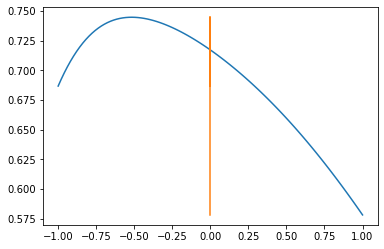

In [21]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

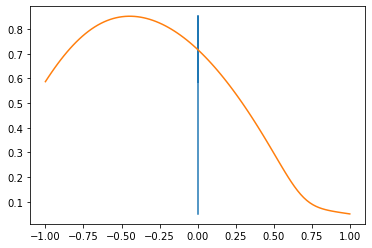

In [22]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

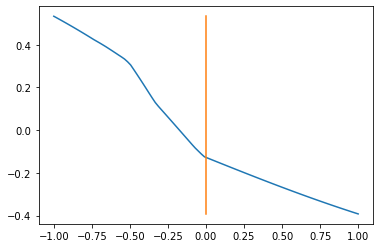

In [23]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

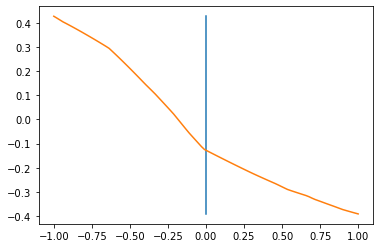

In [24]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [25]:
env = gym.make('MountainCarContinuous-v0')
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 5, daifa.agent_time_ratio, show_env=True)
res

,reward,timesteps,num_actions
0,99.470285,276,46
1,99.517136,240,40
2,99.547462,318,53
3,99.595788,240,40
4,99.422321,246,41


In [26]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=False)

Episode 1
[-0.557159  0.      ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
6 19
20
Success in episode 1 at time step 112 with reward 99.17134575054686
Episode 2
[-0.48356014  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
15 32
33
Success in episode 2 at time step 192 with reward 98.60188763678225
Episode 3
[-0.4604462  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
21 36
37
Success in episode 3 at time step 215 wi

In [27]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.304538,150,25
1,99.237528,156,26
2,99.529846,162,27
3,99.235273,192,32
4,99.211968,156,26
5,99.578572,168,28
6,99.270556,162,27
7,99.420982,162,27
8,99.327408,162,27
9,99.267540,216,36


In [28]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=True)

Episode 1
[-0.40980172  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
39 106
107
Success in episode 1 at time step 632 with reward 95.86810373858832
Episode 2
[-0.57013094  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
f

In [29]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,NaN,1002,167
1,NaN,1002,167
2,NaN,1002,167
3,NaN,1002,167
4,NaN,1002,167
5,NaN,1002,167
6,NaN,1002,167
7,NaN,1002,167
8,NaN,1002,167
9,NaN,1002,167


In [30]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 4, daifa.agent_time_ratio, show_env=False)
res

,reward,timesteps,num_actions
0,NaN,1002,167
1,NaN,1002,167
2,NaN,1002,167
3,NaN,1002,167


In [31]:
full_results = pd.concat([results_one, results_two, results_three, results_four])
full_results.reset_index(drop=True)
full_results

,episode,success,sim_steps,VFE_post_run,noise_stddev,percent_use_fast_thinking,total_reward,agent_time_ratio
0,0,False,999,42.384331,"[0.05, 0.05]",0.023952,-7.553369,6
1,1,False,999,28.674154,"[0.05, 0.05]",0.053892,-8.348556,6
2,2,True,720,39.580189,"[0.05, 0.05]",0.025000,92.721712,6
3,3,True,929,21.020830,"[0.05, 0.05]",0.064516,93.833058,6
4,4,True,649,13.975341,"[0.05, 0.05]",0.155963,94.423690,6
...,...,...,...,...,...,...,...,...
45,45,False,999,NaN,"[0.05, 0.05]",0.000000,NaN,6
46,46,False,999,NaN,"[0.05, 0.05]",0.000000,NaN,6
47,47,False,999,NaN,"[0.05, 0.05]",0.000000,NaN,6
48,48,False,999,NaN,"[0.05, 0.05]",0.000000,NaN,6


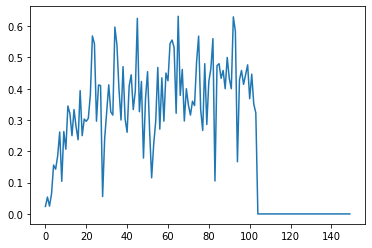

In [32]:
T = np.arange(len(full_results))
plt.plot(T, full_results.percent_use_fast_thinking)

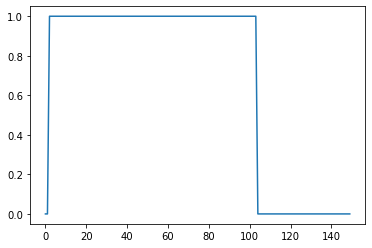

In [33]:
plt.plot(T, full_results.success)

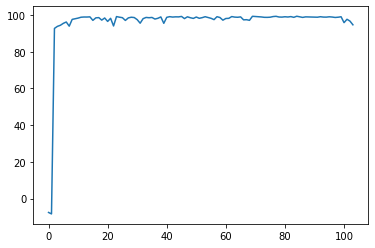

In [34]:
plt.plot(T, full_results.total_reward)

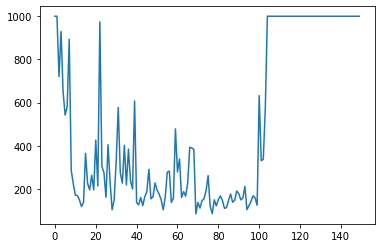

In [35]:
plt.plot(T, full_results.sim_steps)